# Athlete Trend Extraction
Extract some common trends for each athlete in the dataset. That data can then be used to fill a UI where an athlete's trends can be looked up.

In [48]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy.stats import percentileofscore

In [49]:
full_rounds = pd.read_csv('../data/full/rounds_with_splits.csv')
laptimes = pd.read_csv('../data/full/individual_athlete_lap_data.csv')

C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (9,10,20,21,23,24,26,27,29,32,35,38,41,44,47,50,53,56,59,102,105,108,110,111,114,117,120,123,126,129,132,135,138,141,144,147,150,152,153) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


##### Data Cleaning
TODO move this cleaning to the processing in the web scraper.

In [50]:
full_rounds.columns[:20]

Index(['season', 'competition', 'event', 'instance_of_event_in_competition',
       'gender', 'round', 'race', 'Place', 'Start Pos.', 'Warn.', 'Relay Team',
       '#', 'Name', 'ISU ID', 'ISU Member', 'Results', 'Qual.', 'Points',
       'laps_of_split_data', 'lap_1_position'],
      dtype='object')

In [51]:
# Convert laptimes to float. Any laptimes larger than one minute are outliers anyway, so convert to NaN 
laptime_cols = [f'lap_{l}_laptime' for l in range(1, 46)]
for lc in laptime_cols:
    full_rounds[lc] = pd.to_numeric(full_rounds[lc], errors='coerce', downcast='float')
    
# Convert elapsed time to seconds. Non-confirming objects are converted to NaN
def elapsed_to_seconds(et):
    try:
        if isinstance(et, float):
            return et
        ms_split = et.split('.')
        s = sum(int(x) * 60 ** i for i, x in enumerate(reversed(ms_split[0].split(':'))))
        ms = (int(ms_split[-1]) / 100) if int(ms_split[-1]) < 100 else (int(ms_split[-1]) / 1000)
        return s + ms
    except:
        return np.nan
elapsed_cols = [f'lap_{l}_elapsedtime' for l in range(1, 46)]
for ec in elapsed_cols:
    full_rounds[ec] = full_rounds[ec].apply(lambda et: elapsed_to_seconds(et))

# same conversions for lap-by-lap data
laptimes['laptime'] = pd.to_numeric(laptimes['laptime'], errors='coerce', downcast='float')
laptimes = laptimes.astype({'lap': int})

In [52]:
individual_events = full_rounds[full_rounds['event'].isin({'500m', '1000m', '1500m'})]

In [53]:
individual_events.Name.value_counts()[:20]

CharlesHAMELIN              693
AriannaFONTANA              663
NicolaRODIGARI              659
EvgeniaRADANOVA             650
KaterinaNOVOTNA             634
CONFORTOLAYuri              622
ThibautFAUCONNET            607
BYKANOVVladislav            574
JonELEY                     570
EliseCHRISTIE               565
TatianaBORODULINA           550
NielsKERSTHOLT              547
ViktorKNOCH                 537
KNEGTSjinkie                535
ELISTRATOVSemen             513
VeroniquePIERRON            507
VeronikaWINDISCH            488
FreekvanderWART             483
MarinaGEORGIEVA-NIKOLOVA    472
BernadettHEIDUM             463
Name: Name, dtype: int64

In [54]:
individual_events.shape

(128932, 154)

Select one athlete to be compared against all the other athletes of their gender.

In [55]:
name = 'KaterinaNOVOTNA'
athlete_races = individual_events[individual_events['Name'] == name]
athlete_laptimes = laptimes[laptimes['Name'] == name]
athlete_gender = athlete_races.iloc[0]['gender']
comparison_races = individual_events[(individual_events['gender'] == athlete_gender) & (individual_events['Name'] != name)]
comparison_laptimes = laptimes[(laptimes['gender'] == athlete_gender) & (laptimes['Name'] != name)]

## Most Common Position to Start the Race

#### Single Athlete

event
1000m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1500m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
500m     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

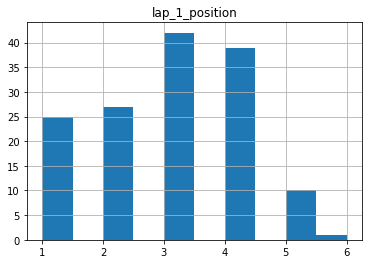

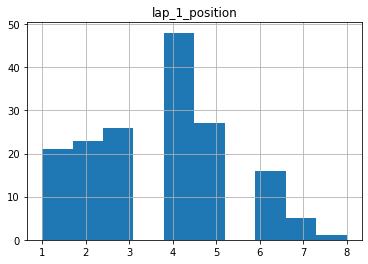

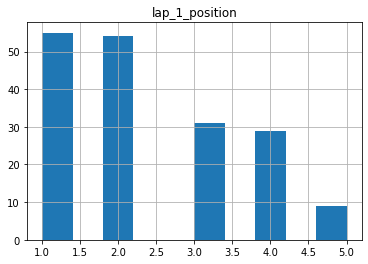

In [56]:
athlete_races[['event', 'lap_1_position']].groupby('event').hist()

#### Gender Benchmark
Not applicable.

## 500m Half-Lap Start Time

In [57]:
# rough way to filter out athletes who fell in the first half-lap
half_lap_upper_threshold = 9

# rough way to filter out erroneous data
half_lap_lower_threshold = 6

#### Single Athlete

In [58]:
start_times = athlete_races[(athlete_races['event'] == '500m')]['lap_1_laptime']
single_athlete_mean_start_time = start_times.mean()
single_athlete_mean_start_time

7.613332

<AxesSubplot:>

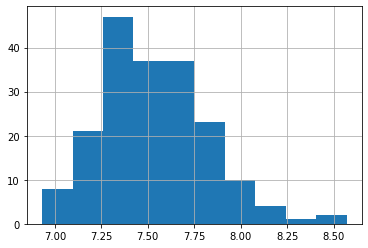

In [59]:
start_times[(start_times < half_lap_upper_threshold) & (start_times > half_lap_lower_threshold)].hist()

#### Gender Benchmark

<AxesSubplot:>

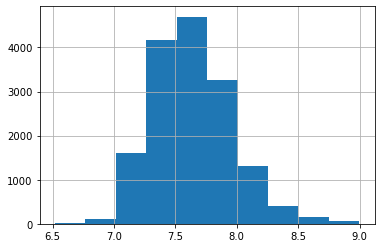

In [60]:
start_times = comparison_races[(comparison_races['event'] == '500m')]['lap_1_laptime']
start_times[(start_times < half_lap_upper_threshold) & (start_times > half_lap_lower_threshold)].hist()

In [61]:
percentileofscore(start_times, single_athlete_mean_start_time, 'rank')

40.294490987560295

## 500m Start Performance
Does the athlete get especially good starts from a particular position on the line?   

#### Single Athlete

Start Pos.
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

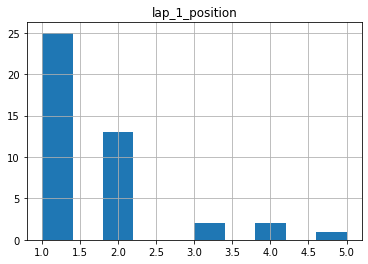

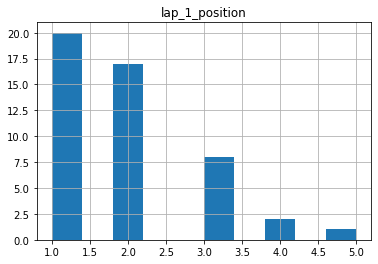

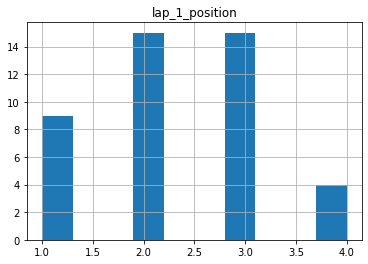

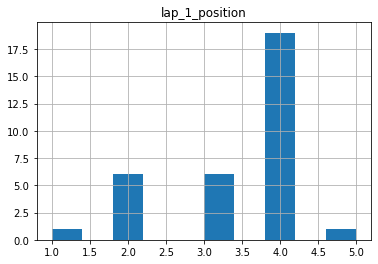

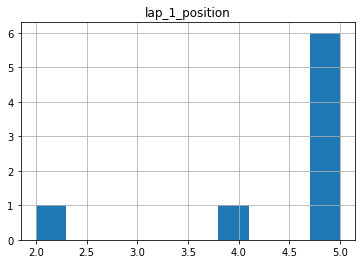

In [62]:
athlete_races[(athlete_races['event'] == '500m') & 
              (athlete_races['lap_1_laptime'] < half_lap_upper_threshold) &
              (athlete_races['lap_1_laptime'] > half_lap_lower_threshold)][['Start Pos.', 'lap_1_position']].groupby('Start Pos.').hist()

#### Gender Benchmark

Start Pos.
1    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
2    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
3    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
4    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
5    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
6    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

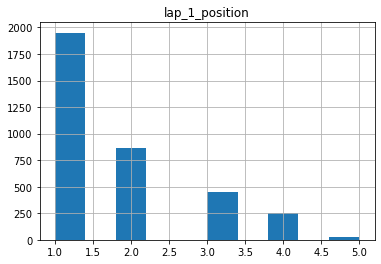

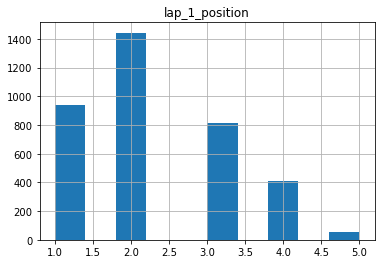

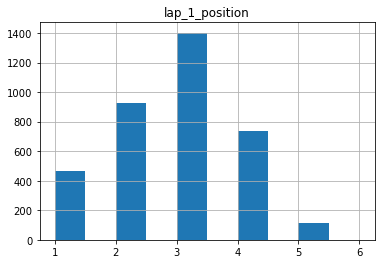

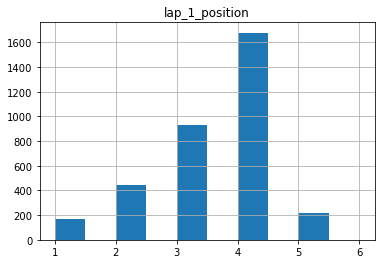

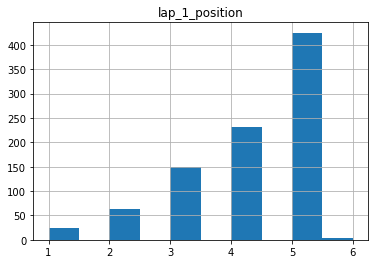

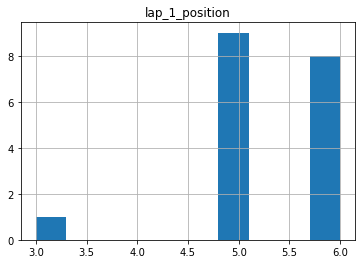

In [63]:
comparison_races[(comparison_races['event'] == '500m') & 
                 (comparison_races['lap_1_laptime'] < half_lap_upper_threshold) &
                 (comparison_races['lap_1_laptime'] > half_lap_lower_threshold)][['Start Pos.', 'lap_1_position']].groupby('Start Pos.').hist()

## Top Speed
Split based on whether the athlete was leading or following.

In [64]:
leading_fastest_laps_fraction = 0.01
following_fastest_laps_fraction = 0.01

#### Single Athlete

In [65]:
# fastest laptimes when leading
single_athlete_leading_laptimes = athlete_laptimes[athlete_laptimes['lap_end_position'] == 1]['laptime'] 
single_athlete_best_leading_laptime = single_athlete_leading_laptimes.nsmallest(int(leading_fastest_laps_fraction * len(single_athlete_leading_laptimes))).mean()
single_athlete_best_leading_laptime

8.89475

In [66]:
# fastest laptimes when following
single_athlete_following_laptimes = athlete_laptimes[athlete_laptimes['lap_end_position'] != 1]['laptime'] 
single_athlete_best_following_laptime = single_athlete_following_laptimes.nsmallest(int(following_fastest_laps_fraction * len(single_athlete_following_laptimes))).mean()
single_athlete_best_following_laptime

8.927703

#### Gender Benchmark

In [68]:
benchmark_leading_laptimes = comparison_laptimes[comparison_laptimes['lap_end_position'] == 1]['laptime'] 
100 - percentileofscore(benchmark_leading_laptimes.nsmallest(int(leading_fastest_laps_fraction * len(benchmark_leading_laptimes))), single_athlete_leading_laptime, 'rank')

0.0

In [69]:
benchmark_following_laptimes = comparison_laptimes[comparison_laptimes['lap_end_position'] != 1]['laptime'] 
100 - percentileofscore(benchmark_following_laptimes.nsmallest(int(following_fastest_laps_fraction * len(benchmark_following_laptimes))), single_athlete_following_laptime, 'rank')

26.577493457400408

## Most Likely Lap to Pass

#### Single Athlete

C:\Users\ahale\Anaconda3\envs\shorttrack\lib\site-packages\pandas\plotting\_matplotlib\tools.py:185: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)


event  position_change
1000m  -4.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -0.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1500m  -4.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -0.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        2.0               [[AxesSubplot

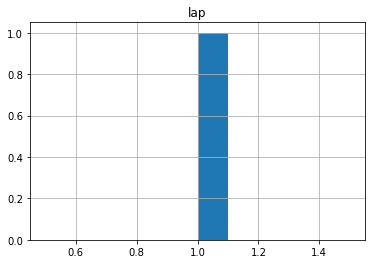

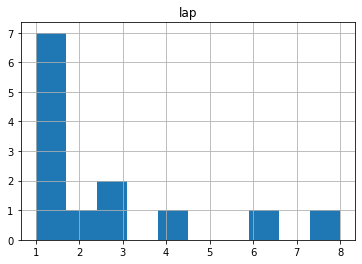

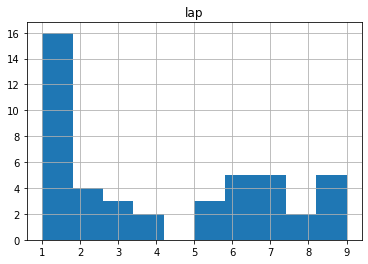

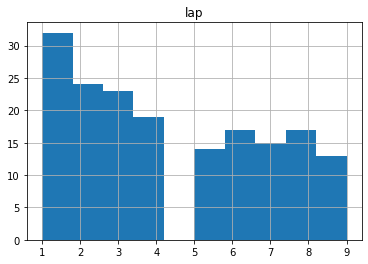

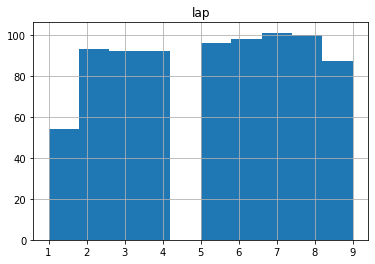

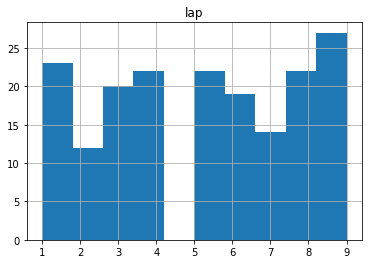

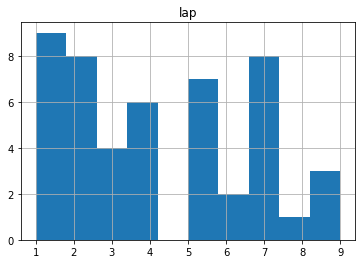

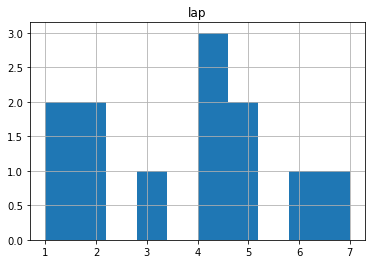

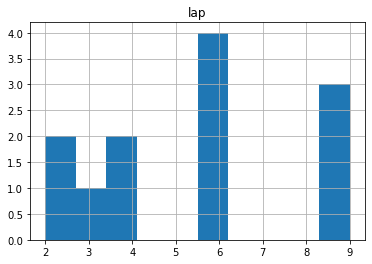

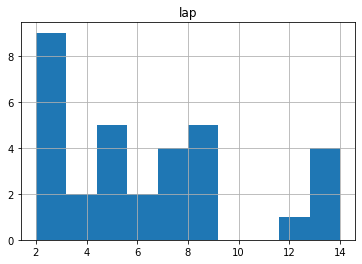

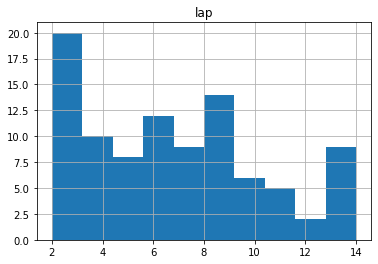

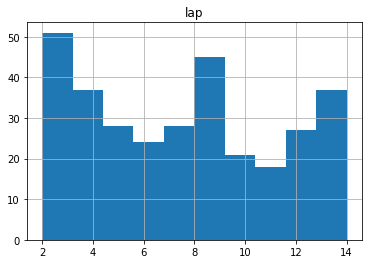

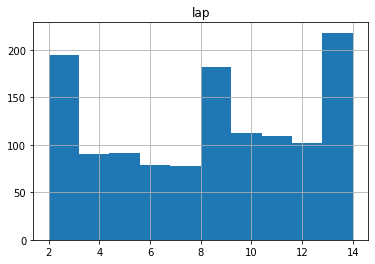

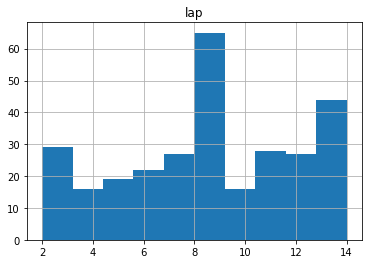

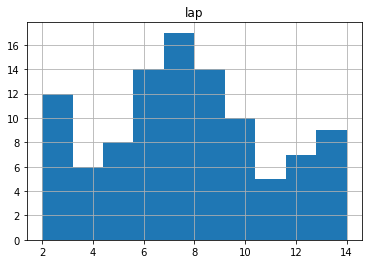

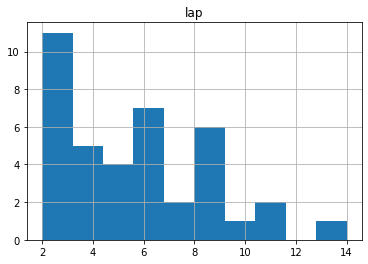

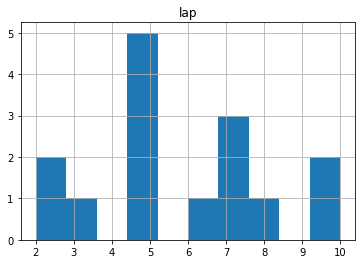

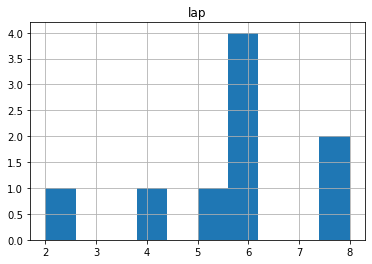

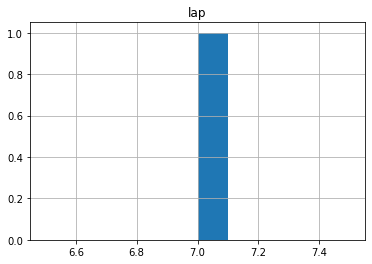

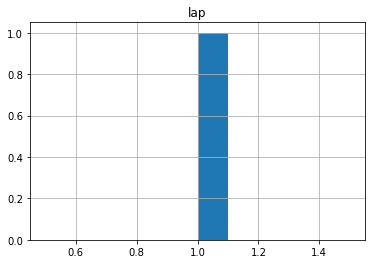

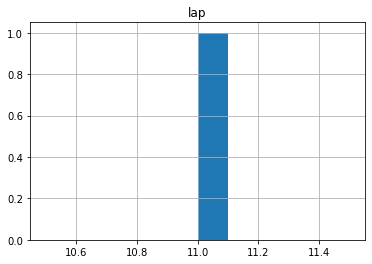

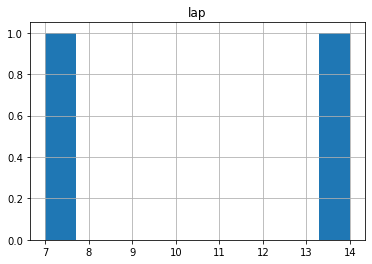

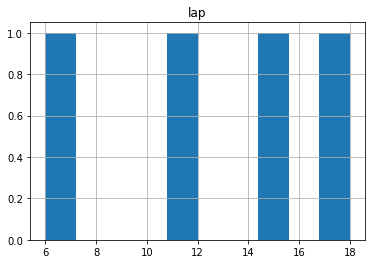

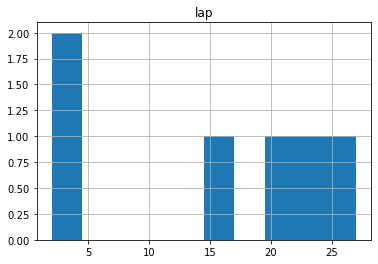

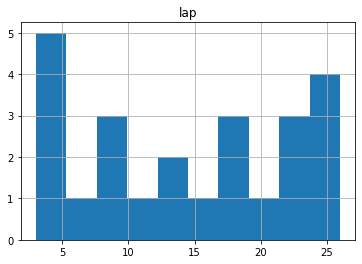

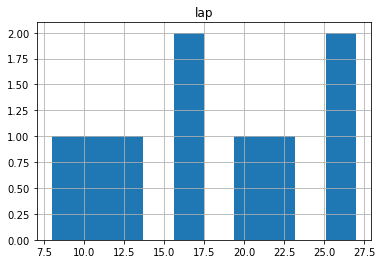

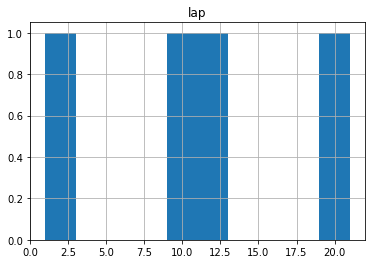

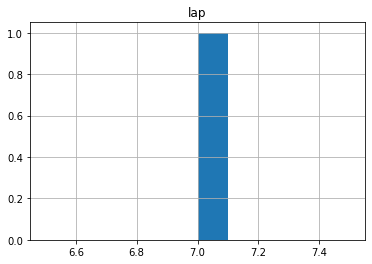

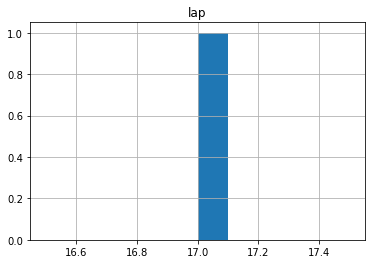

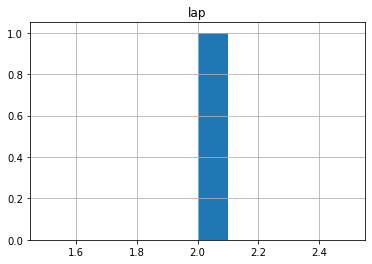

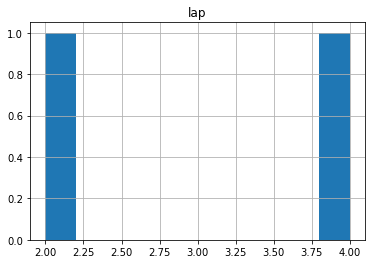

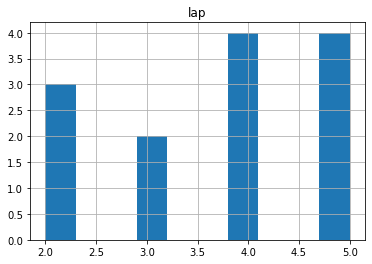

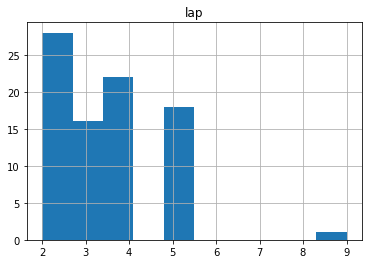

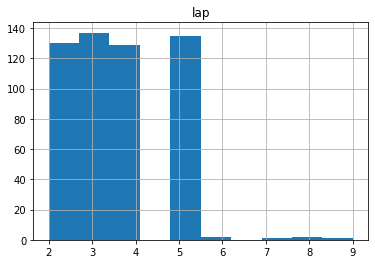

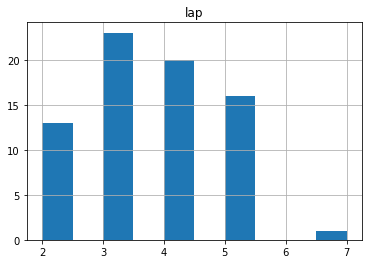

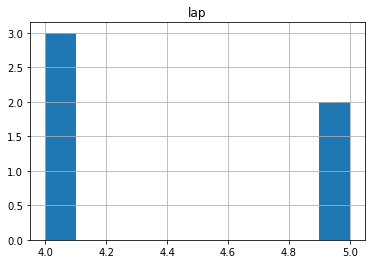

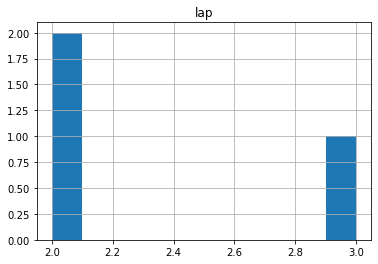

In [70]:
athlete_laptimes[['event', 'lap', 'position_change']].groupby(['event', 'position_change']).hist()

#### Gender Benchmark

event  position_change
1000m  -5.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -4.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
                                            ...                   
500m   -1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
       -0.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        1.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        2.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
        3.0               [[AxesSubplot(0.125,0.125;0.775x0.755)]]
Length: 62, dtype: object

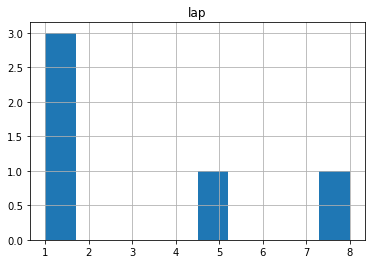

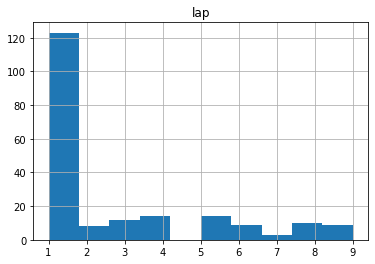

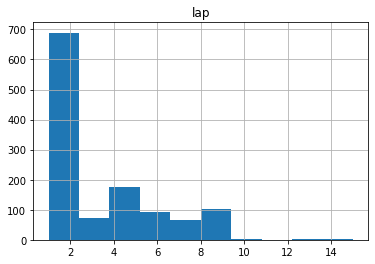

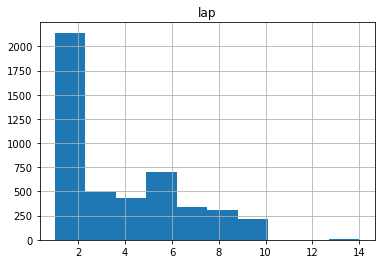

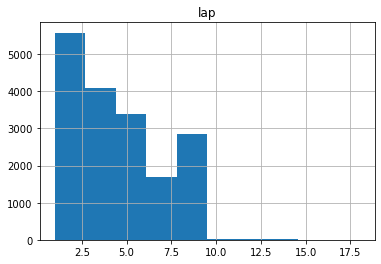

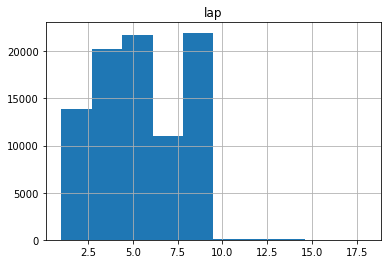

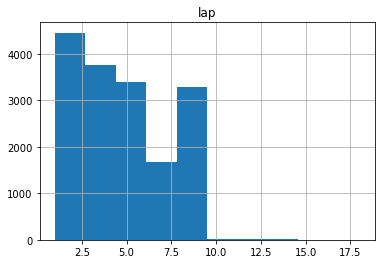

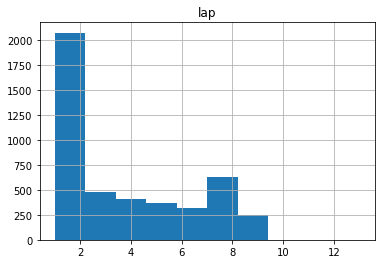

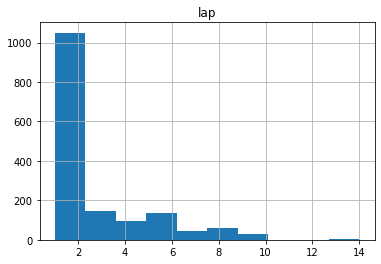

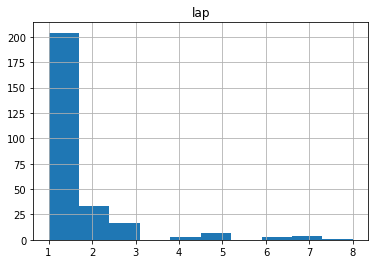

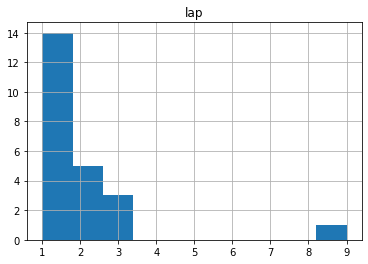

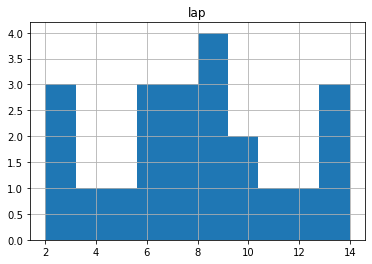

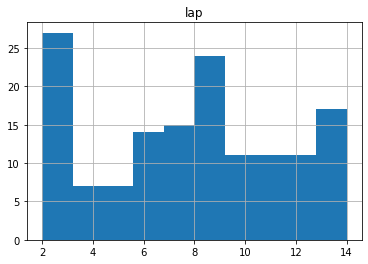

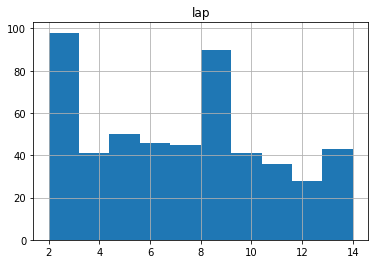

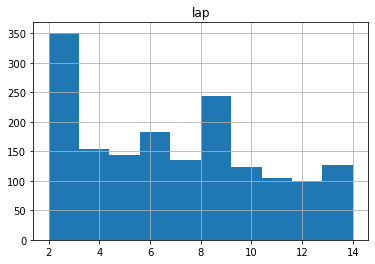

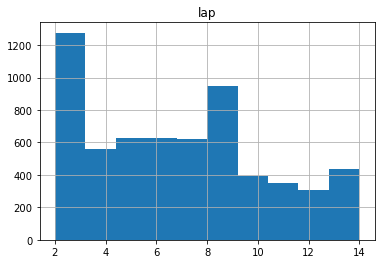

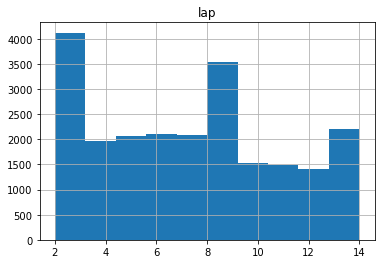

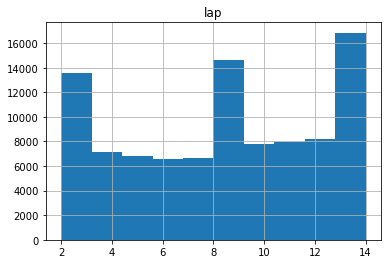

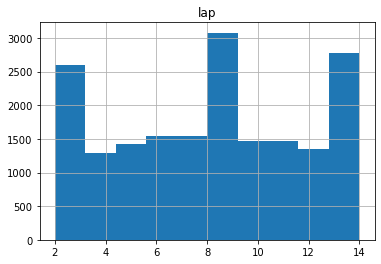

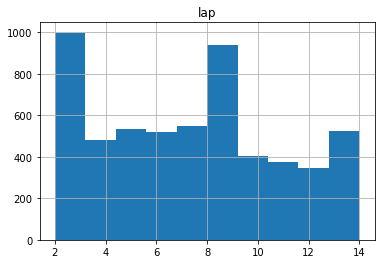

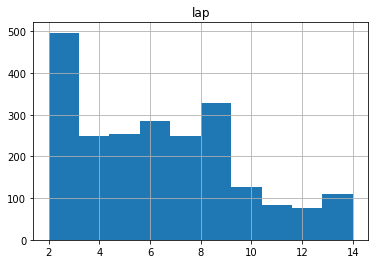

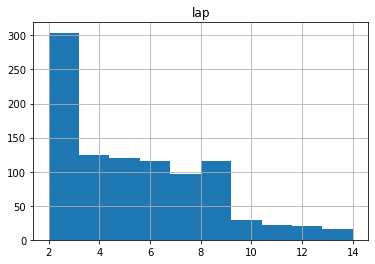

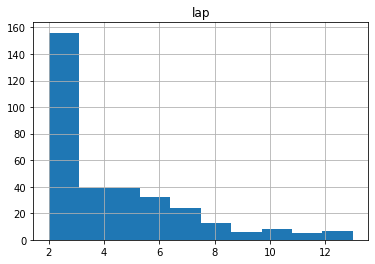

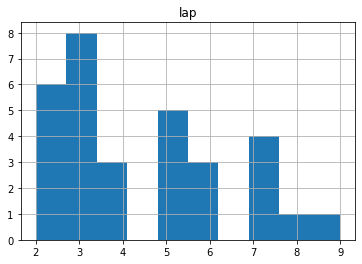

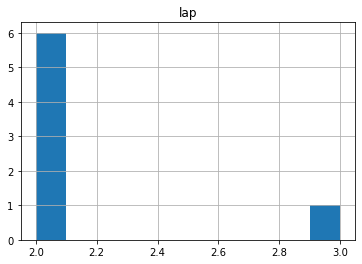

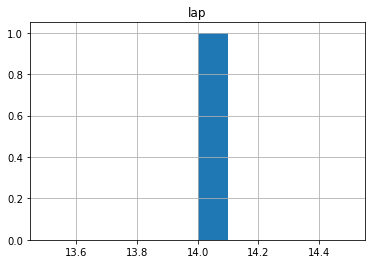

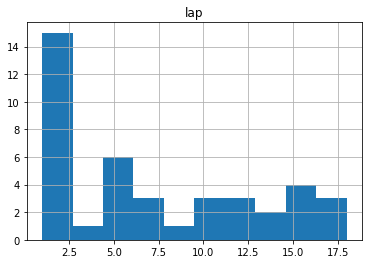

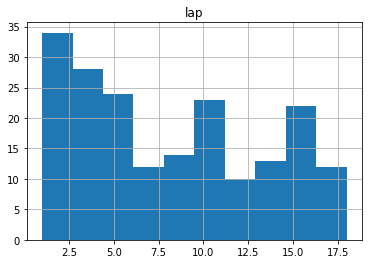

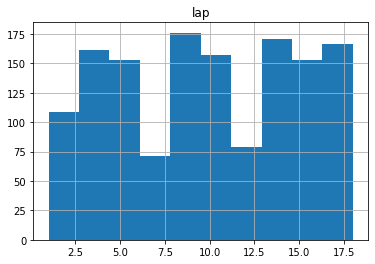

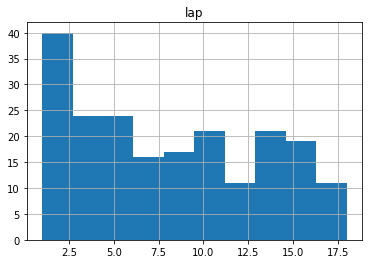

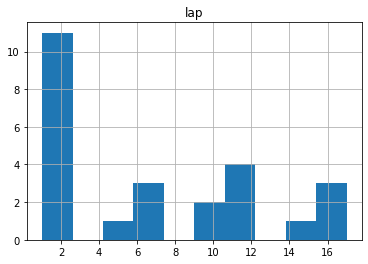

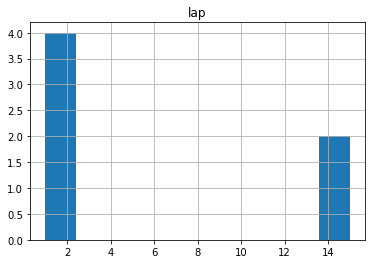

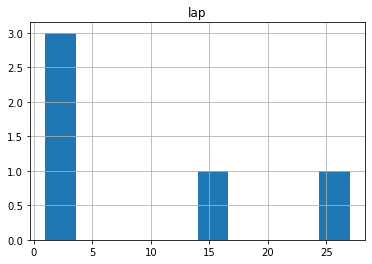

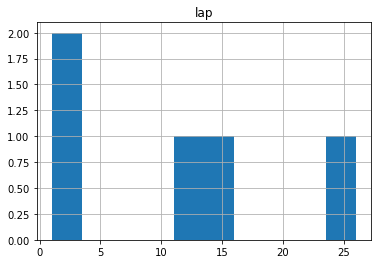

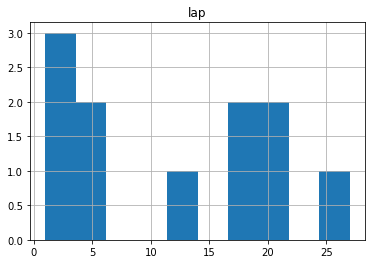

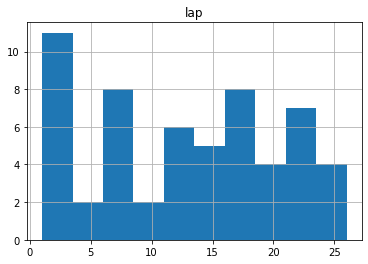

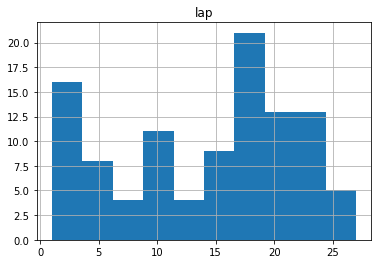

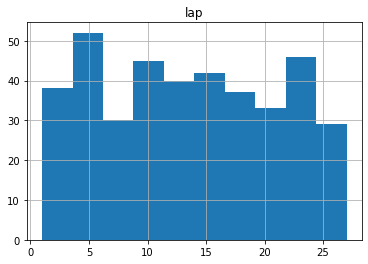

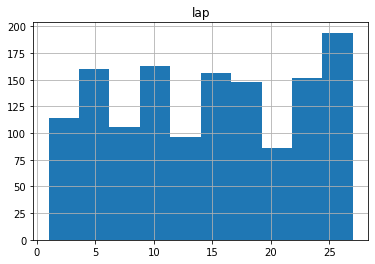

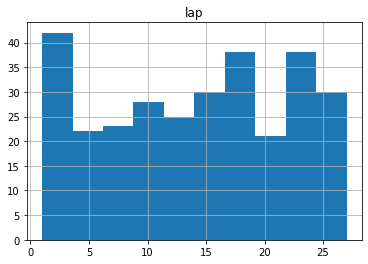

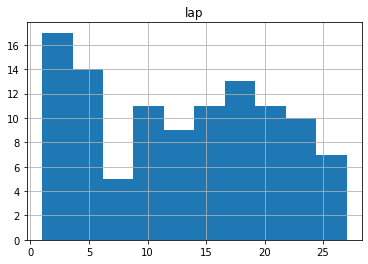

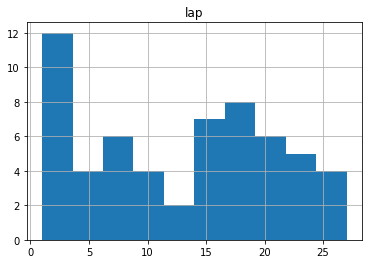

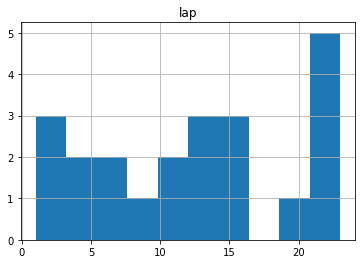

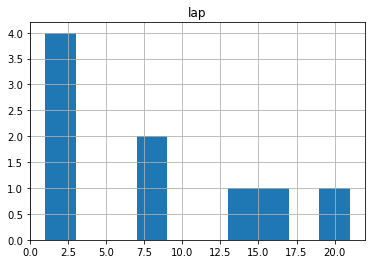

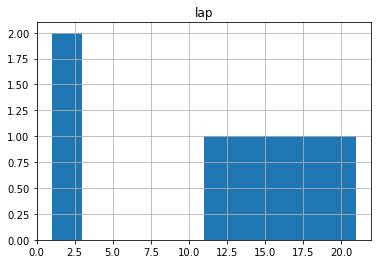

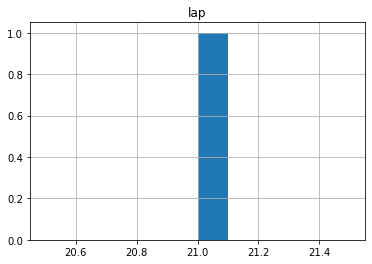

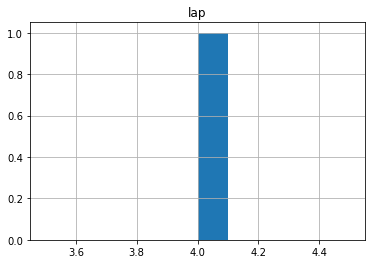

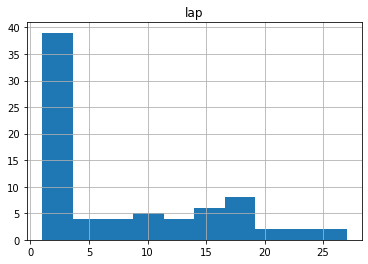

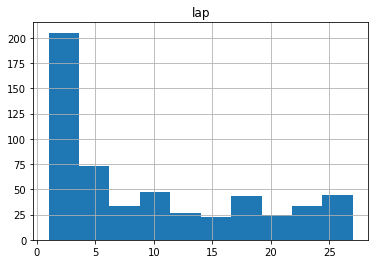

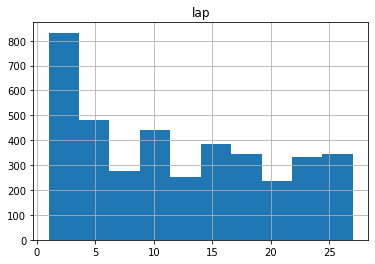

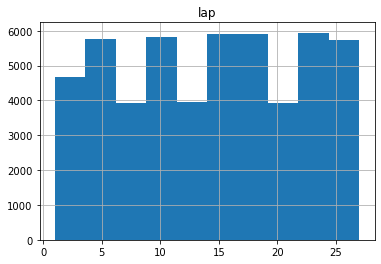

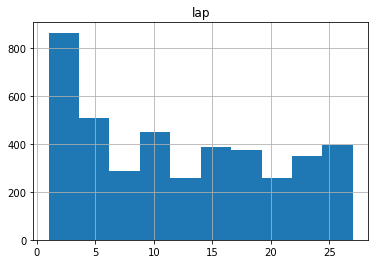

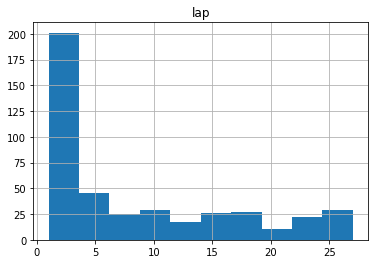

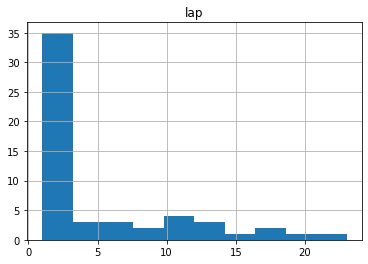

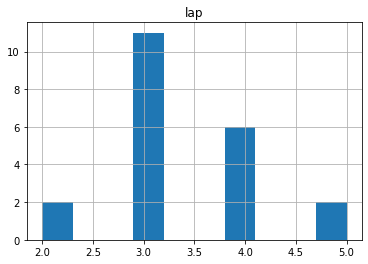

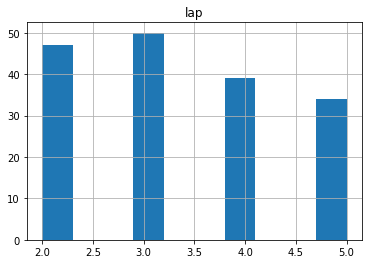

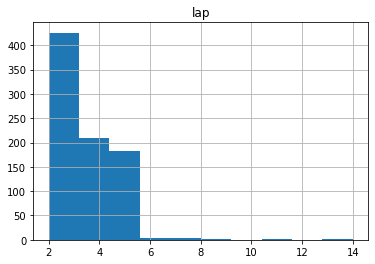

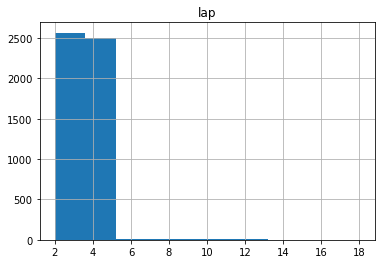

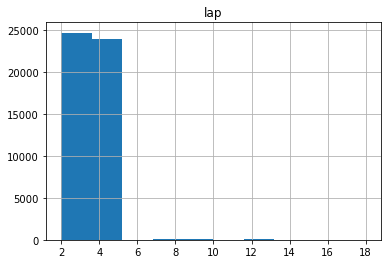

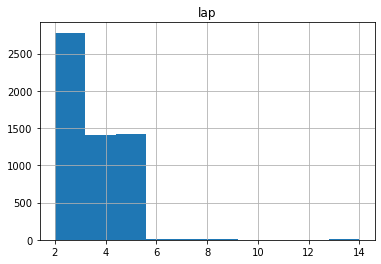

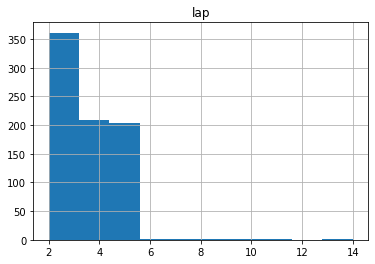

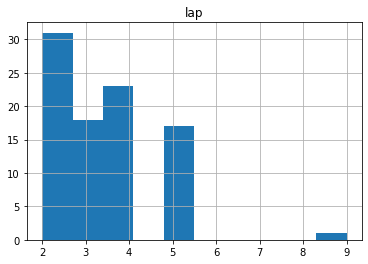

In [71]:
comparison_laptimes[['event', 'lap', 'position_change']].groupby(['event', 'position_change']).hist()

## x+y Position Selection
In a non-final race where multiple people advance, does the athlete typically try to finish in first or settle for a qualifying position?

#### Single Athlete

event
1000m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
1500m    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
500m     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

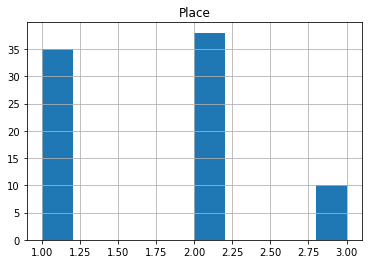

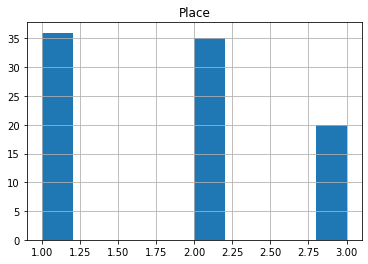

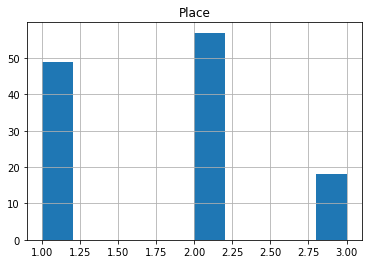

In [72]:
xy_sel = athlete_races[athlete_races['Qual.'].isin(['Q', 'q', 'QA', 'qA'])][['event', 'Place']]
xy_sel['Place'] = pd.to_numeric(xy_sel['Place'], errors='coerce', downcast='integer')
xy_sel.groupby('event').hist()

#### Gender Benchmark
Not applicable.

## 1500m Pacing - Leading Pace
When leading, does the athlete like to start the 1500m race at a fast pace or a slow pace?

#### Single Athlete

In [73]:
single_athlete_1500m_leading_pace = athlete_laptimes[(athlete_laptimes['event'] == '1500m') & 
                                                     (athlete_laptimes['lap'] > 1) & 
                                                     (athlete_laptimes['lap'] < 5) & 
                                                     (athlete_laptimes['lap_start_position'] == 1) &
                                                     (athlete_laptimes['position_change'] == 0)]['laptime'].mean()
single_athlete_1500m_leading_pace

11.936706

#### Gender Benchmark

In [74]:
percentileofscore(comparison_laptimes[(comparison_laptimes['event'] == '1500m') & 
                                      (comparison_laptimes['lap'] > 1) & 
                                      (comparison_laptimes['lap'] < 5) & 
                                      (comparison_laptimes['lap_start_position'] == 1) &
                                      (comparison_laptimes['position_change'] == 0)]['laptime'], single_athlete_1500m_leading_pace, 'rank')

34.0279542566709

## 1500m Pacing - Pace Instigation
If following at the start of a 1500m race, does the athlete make a pass to the front to pick up the pace?

#### Single Athlete

In [75]:
early_passes_to_front = athlete_laptimes[(athlete_laptimes['event'] == '1500m') & 
                                         (athlete_laptimes['lap'] > 1) & 
                                         (athlete_laptimes['lap'] < 5) & 
                                         (athlete_laptimes['lap_start_position'] > 1) &
                                         (athlete_laptimes['lap_end_position'] == 1)]

speed_up_sum = 0
denominator = len(early_passes_to_front)

for idx, early_pass in early_passes_to_front.iterrows():
    previous_laptime = athlete_laptimes[(athlete_laptimes['season'] == early_pass['season']) & 
                                        (athlete_laptimes['competition'] == early_pass['competition']) & 
                                        (athlete_laptimes['event'] == early_pass['event']) & 
                                        (athlete_laptimes['gender'] == early_pass['gender']) &
                                        (athlete_laptimes['round'] == early_pass['round']) &
                                        (athlete_laptimes['race'] == early_pass['race']) &
                                        (athlete_laptimes['instance_of_event_in_competition'] == early_pass['instance_of_event_in_competition']) &
                                        (athlete_laptimes['lap'] == early_pass['lap'] - 1)]
    if len(previous_laptime):
        speed_up_sum += previous_laptime.iloc[0]['laptime'] - early_pass['laptime']
    else:
        denominator -= 1

print(speed_up_sum / denominator)

0.636076780465933


#### Gender Benchmark

In [ ]:
early_passes_to_front = comparison_laptimes[(comparison_laptimes['event'] == '1500m') & 
                                            (comparison_laptimes['lap'] > 1) & 
                                            (comparison_laptimes['lap'] < 5) & 
                                            (comparison_laptimes['lap_start_position'] > 1) &
                                            (comparison_laptimes['lap_end_position'] == 1)]

speed_up_sum = 0
denominator = len(early_passes_to_front)

for idx, early_pass in early_passes_to_front.iterrows():
    previous_laptime = comparison_laptimes[(comparison_laptimes['season'] == early_pass['season']) & 
                                           (comparison_laptimes['competition'] == early_pass['competition']) & 
                                           (comparison_laptimes['event'] == early_pass['event']) & 
                                           (comparison_laptimes['gender'] == early_pass['gender']) &
                                           (comparison_laptimes['round'] == early_pass['round']) &
                                           (comparison_laptimes['race'] == early_pass['race']) &
                                           (comparison_laptimes['instance_of_event_in_competition'] == early_pass['instance_of_event_in_competition']) &
                                           (comparison_laptimes['lap'] == early_pass['lap'] - 1)]
    if len(previous_laptime):
        speed_up_sum += previous_laptime.iloc[0]['laptime'] - early_pass['laptime']
    else:
        denominator -= 1

print(speed_up_sum / denominator)

## Performance in Races with Many / Few Skaters

#### Single Athlete

In [ ]:
# TODO

#### Gender Comparison
Not applicable.

## Win Rate
In a Final, how often does this athlete win?

#### Single Athlete

In [ ]:
# TODO

#### Gender Comparison
Not applicable.

## Medal Rate
In a Final, how often does this athlete receive a medal?

#### Single Athlete

In [ ]:
# TODO

#### Gender Comparison
Not applicable.

## Advancement Rate
In each non-Final round, how often does this athlete advance to the next round?

#### Single Athlete

In [ ]:
# TODO

#### Gender Comparison
Not applicable.

## Penalty Rate
How often does this athlete receive a penalty? Which type of penalty do they receive most often?

#### Single Athlete

In [ ]:
# TODO

#### Gender Comparison

In [ ]:
# TODO